In [1]:
import json
import logging
import pandas as pd

from modeling import get_order, Runner
from plotnine import *

logger = logging.getLogger()
logger.setLevel(logging.INFO)

ModuleNotFoundError: No module named 'modeling'

## Load dataset

In [2]:
from sklearn.datasets import load_wine
wine = load_wine(as_frame = True).frame
wine["target2"] = (wine.target==1).astype(int).astype(int)
wine.loc[:,"row_id"] = wine.index

## Running Locally
### Cross Validation

In [3]:
from modeling import validate_config
import json

with open('cv_reg_config.json', 'r') as config_file:
    config = json.load(config_file)

validate_config(config = config)

True

In [4]:
with open('cv_reg_config.json', 'r') as config_file:
    config = json.load(config_file)

order = get_order(df = wine, config = config)

from modeling.processors import SequentialProcessor
processor = SequentialProcessor()

runner = Runner(processor = processor)
runner.run(order = order)

INFO:root:Order f1b9d30d-3575-42ed-a56a-07524cc98718 - started.
INFO:root:Order f1b9d30d-3575-42ed-a56a-07524cc98718 - adding result. 1 / 6 tasks completed.
INFO:root:Order f1b9d30d-3575-42ed-a56a-07524cc98718 - adding result. 2 / 6 tasks completed.
INFO:root:Order f1b9d30d-3575-42ed-a56a-07524cc98718 - adding result. 3 / 6 tasks completed.
INFO:root:Order f1b9d30d-3575-42ed-a56a-07524cc98718 - adding result. 4 / 6 tasks completed.
INFO:root:Order f1b9d30d-3575-42ed-a56a-07524cc98718 - adding result. 5 / 6 tasks completed.
INFO:root:Order f1b9d30d-3575-42ed-a56a-07524cc98718 - adding result. 6 / 6 tasks completed.
INFO:root:Order f1b9d30d-3575-42ed-a56a-07524cc98718 - finished.


In [4]:
evaldf = pd.DataFrame(order.get_results()['eval'])
evaldf.head()

,index,task_id,param_id,split_id,sklearn:mean_squared_error,sklearn:mean_absolute_error,num_boost_round,objective,eval_metric,eta,max_depth
0,0,1,1,0,2.127553,1.261351,1000,reg:squarederror,rmse,0.3,6
1,0,1,1,0,2.127553,1.261351,500,reg:squarederror,rmse,0.3,6
2,0,3,0,1,0.565899,0.602064,1000,reg:squarederror,rmse,0.3,4
3,0,3,0,1,0.565899,0.602064,500,reg:squarederror,rmse,0.3,4
4,0,0,0,0,1.885999,1.187294,1000,reg:squarederror,rmse,0.3,4


In [6]:
def make_cv_plot(df, metric_name):
    display = df.copy()
    display.loc[:, 'split_id'] = display.split_id.astype(str)
    p1 = (ggplot(display, aes(x = 'param_id', y = metric_name, color = 'split_id'))
          + geom_point(size = 5, show_legend = True)
          + theme_minimal()
          + labs(title = metric_name, x = 'Metaparameter Grouping')
          + scale_y_continuous(expand = (0.2,0))
          + scale_x_continuous(expand = (0.2,0))
         )
    return p1

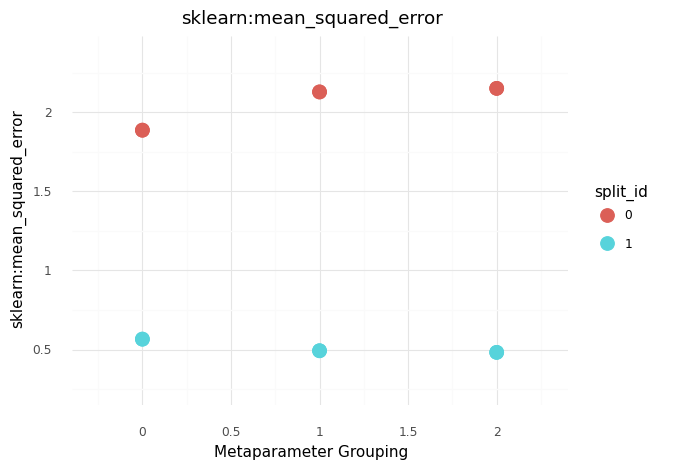

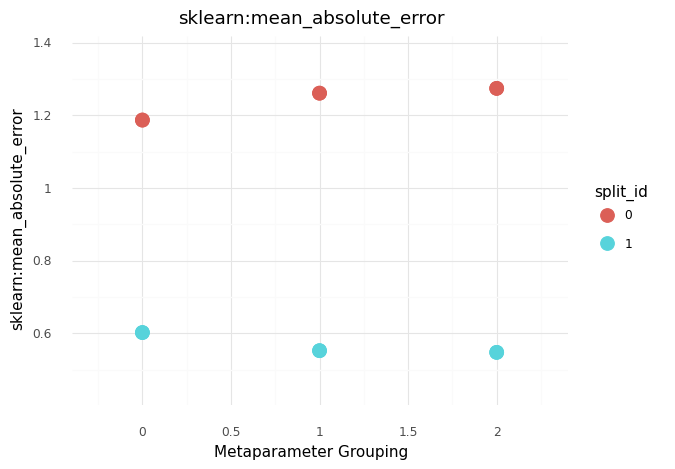

In [6]:
for metric in config['validation']['evalulation']['metrics']:
    print(make_cv_plot(df = evaldf, metric_name = metric))

### Single Model Training (no cross validaiton)

In [3]:
with open('reg_config.json', 'r') as config_file:
    config = json.load(config_file)
    
order = get_order(df = wine, config = config)

runner = Runner(workers = 4)
runner.run(order = order)

INFO:root:Order 10c61568-59d9-4564-bdf0-ef403e0cffbc - started.


SystemExit: 'num_boost_round'

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.


In [4]:
type(order)

modeling.orders.TrainOrder

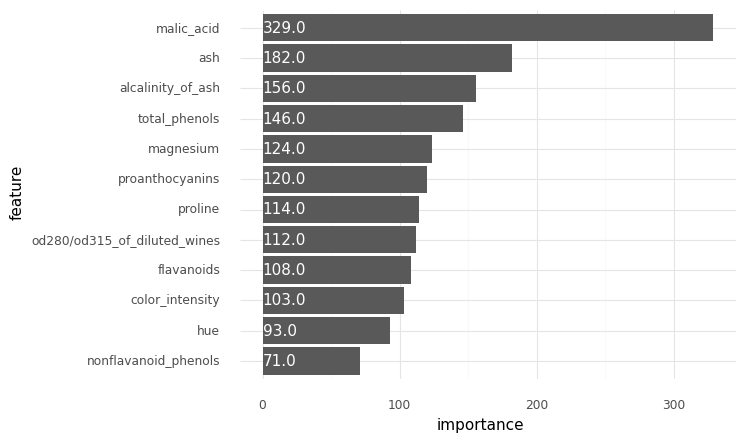

<ggplot: (8744177746698)>

In [4]:
m = order.get_results()
display = pd.DataFrame({'feature': m._model.get_fscore().keys(), 'importance': m._model.get_fscore().values()})
display = display.sort_values(by = 'importance', ascending = False).head(25).sort_values(by = 'importance', ascending = True)

(ggplot(display, aes(x = 'feature', y = 'importance'))
 + geom_bar(stat = 'identity')
 + geom_text(aes(x = 'feature', y = 0, label = 'importance'), ha = 'left', color = 'white')
 + scale_x_discrete(limits = display.feature.tolist())
 + coord_flip()
 + theme_minimal())

## Hosted as a web service

In [9]:
import requests
request = f'http://0.0.0.0:5051/train'
r = requests.post(request,
                  json = {"config": config,
                          "df": wine.to_dict()})
job_id = r.text
print(job_id)

30afce6a-b42d-4763-b937-8017153fdf0c


In [11]:
request = f'http://0.0.0.0:5051/train/status/{job_id}'
r = requests.get(request)
r.text

'0 / 6 tasks completed.'

In [14]:
request = f'http://0.0.0.0:5051/train/jobs'
r = requests.get(request)
r.text

'30afce6a-b42d-4763-b937-8017153fdf0c'

In [12]:

import inspect
list(inspect.signature(make_cv_plot).parameters.keys())

['df', 'metric_name']